In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
TRAIN_CSV = "/kaggle/input/lmsys-chatbot-arena/train.csv"
TEST_CSV = "/kaggle/input/lmsys-chatbot-arena/test.csv"
SS_CSV = "/kaggle/input/lmsys-chatbot-arena/sample_submission.csv"
train = pd.read_csv(TRAIN_CSV)
test = pd.read_csv(TEST_CSV)
ss = pd.read_csv(SS_CSV)

In [34]:
!pip install -U sentence-transformers
!pip install textstat==0.6.2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 1.1 MB/s eta 0:00:00 0:00:010m
  Attempting uninstall: textstat
    Found existing installation: textstat 0.7.3
    Uninstalling textstat-0.7.3:
      Successfully uninstalled textstat-0.7.3


In [5]:
from sentence_transformers import SentenceTransformer

from tqdm import tqdm

model = SentenceTransformer("multi-qa-mpnet-base-cos-v1")

'''
train[['similar_a','similar_b']] = 0.0

for i in tqdm(range(0, len(train))):
    query_embedding = model.encode(train.iloc[i]['prompt'], show_progress_bar=False)
    passage_embeddings = model.encode([
        train.iloc[i]['response_a'], train.iloc[i]['response_b']
    ], show_progress_bar=False)
    sim = model.similarity(query_embedding, passage_embeddings).numpy()
    train.at[i, 'similar_a'] = sim[0][0]
    train.at[i, 'similar_b'] = sim[0][1]

train.head()
'''

2024-06-02 20:28:12.484820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 20:28:12.484949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 20:28:12.655721: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.25k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

"\ntrain[['similar_a','similar_b']] = 0.0\n\nfor i in tqdm(range(0, len(train))):\n    query_embedding = model.encode(train.iloc[i]['prompt'], show_progress_bar=False)\n    passage_embeddings = model.encode([\n        train.iloc[i]['response_a'], train.iloc[i]['response_b']\n    ], show_progress_bar=False)\n    sim = model.similarity(query_embedding, passage_embeddings).numpy()\n    train.at[i, 'similar_a'] = sim[0][0]\n    train.at[i, 'similar_b'] = sim[0][1]\n\ntrain.head()\n"

In [6]:
test[['similar_a','similar_b']] = 0.0

for i in tqdm(range(0, len(test))):
    query_embedding = model.encode(test.iloc[i]['prompt'])
    passage_embeddings = model.encode([
        test.iloc[i]['response_a'], test.iloc[i]['response_b']
    ], show_progress_bar=False)
    sim = model.similarity(query_embedding, passage_embeddings).numpy()
    test.at[i, 'similar_a'] = sim[0][0]
    test.at[i, 'similar_b'] = sim[0][1]

test.head()

  0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


,id,prompt,response_a,response_b,similar_a,similar_b
0,136060,"[""I have three oranges today, I ate an orange ...","[""You have two oranges today.""]","[""You still have three oranges. Eating an oran...",0.786466,0.805637
1,211333,"[""You are a mediator in a heated political deb...","[""Thank you for sharing the details of the sit...","[""Mr Reddy and Ms Blue both have valid points ...",0.596917,0.517899
2,1233961,"[""How to initialize the classification head wh...","[""When you want to initialize the classificati...","[""To initialize the classification head when p...",0.817718,0.765046


In [7]:
#model.save('similar_model')

In [8]:
from sentence_transformers import CrossEncoder
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2",
                     device=device, default_activation_function=torch.nn.Sigmoid())

#model.save('score_model')

'''
train[['score_a','score_b']] = 0.0

for i in tqdm(range(0, len(train))):
    scores = model.predict([
        (train.iloc[i]['prompt'], train.iloc[i]['response_a']),
        (train.iloc[i]['prompt'], train.iloc[i]['response_b']),
    ], show_progress_bar=False)
    train.at[i, 'score_a'] = scores[0]
    train.at[i, 'score_b'] = scores[1]

train.head()
'''

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

"\ntrain[['score_a','score_b']] = 0.0\n\nfor i in tqdm(range(0, len(train))):\n    scores = model.predict([\n        (train.iloc[i]['prompt'], train.iloc[i]['response_a']),\n        (train.iloc[i]['prompt'], train.iloc[i]['response_b']),\n    ], show_progress_bar=False)\n    train.at[i, 'score_a'] = scores[0]\n    train.at[i, 'score_b'] = scores[1]\n\ntrain.head()\n"

In [9]:
test[['score_a','score_b']] = 0.0

for i in tqdm(range(0, len(test))):
    scores = model.predict([
        (test.iloc[i]['prompt'], test.iloc[i]['response_a']),
        (test.iloc[i]['prompt'], test.iloc[i]['response_b']),
    ], show_progress_bar=False)
    test.at[i, 'score_a'] = scores[0]
    test.at[i, 'score_b'] = scores[1]

test.head()

100%|██████████| 3/3 [00:00<00:00, 17.56it/s]


,id,prompt,response_a,response_b,similar_a,similar_b,score_a,score_b
0,136060,"[""I have three oranges today, I ate an orange ...","[""You have two oranges today.""]","[""You still have three oranges. Eating an oran...",0.786466,0.805637,0.998082,0.999519
1,211333,"[""You are a mediator in a heated political deb...","[""Thank you for sharing the details of the sit...","[""Mr Reddy and Ms Blue both have valid points ...",0.596917,0.517899,0.141736,0.819197
2,1233961,"[""How to initialize the classification head wh...","[""When you want to initialize the classificati...","[""To initialize the classification head when p...",0.817718,0.765046,0.999782,0.999721


In [25]:
train = pd.read_csv('/kaggle/input/train-data/train.csv')

def process(input_str):
    stripped_str = input_str.strip('[]')
    sentences = [s.strip('"') for s in stripped_str.split('","')]
    return  ' '.join(sentences)

train.loc[:, 'prompt'] = train['prompt'].apply(process)
train.loc[:, 'response_a'] = train['response_a'].apply(process)
train.loc[:, 'response_b'] = train['response_b'].apply(process)
test.loc[:, 'prompt'] = test['prompt'].apply(process)

test.loc[:, 'response_a'] = test['response_a'].apply(process)
test.loc[:, 'response_b'] = test['response_b'].apply(process)

train['similar_diff'] = train['similar_a'] - train['similar_b']
test['similar_diff'] = test['similar_a'] - test['similar_b']

train['score_diff'] = train['score_a'] - train['score_b']
test['score_diff'] = test['score_a'] - test['score_b']

target_cols = ['winner_model_a', 'winner_model_b', 'winner_tie']

train['length_prompt'] = train['prompt'].str.len()
train['length_a'] = train['response_a'].str.len()
train['length_b'] = train['response_b'].str.len()

train['winner'] = 0
train.loc[train['winner_model_a'] == 1, 'winner'] = 0
train.loc[train['winner_model_b'] == 1, 'winner'] = 2
train.loc[train['winner_tie'] == 1, 'winner'] = 1
train['length_diff'] = train['length_a'] - train['length_b']
# length of responses/length of prompt
train['length_diff_comp'] = train['length_diff'] / train['length_prompt']

test['length_prompt'] = test['prompt'].str.len()
test['length_a'] = test['response_a'].str.len()
test['length_b'] = test['response_b'].str.len()
test['length_diff'] = test['length_a'] - test['length_b']
test['length_diff_comp'] = test['length_diff'] / test['length_prompt']

In [26]:
# '**...**' bold, '- '/'* ' bullet-point, '\\n' enter, '```' code-chunk
train['bold_diff'] = train['response_a'].str.count(r'\*\*')/2 - train['response_b'].str.count(r'\*\*')/2
train['point_diff'] = train['response_a'].str.count('- ') + train['response_a'].str.count(r'\\n* ') - train['response_b'].str.count('- ') - train['response_b'].str.count(r'\\n* ')
train['enter_diff'] = train['response_a'].str.count(r'\\n') - train['response_b'].str.count(r'\\n')
train['code_diff'] = train['response_a'].str.count('```')/2 - train['response_b'].str.count('```')/2

test['bold_diff'] = test['response_a'].str.count(r'\*\*')/2 - test['response_b'].str.count(r'\*\*')/2
test['point_diff'] = test['response_a'].str.count('- ') + test['response_a'].str.count(r'\\n* ') - test['response_b'].str.count('- ') - test['response_b'].str.count(r'\\n* ')
test['enter_diff'] = test['response_a'].str.count(r'\\n') - test['response_b'].str.count(r'\\n')
test['code_diff'] = test['response_a'].str.count('```')/2 - test['response_b'].str.count('```')/2

# Admit limits
train['admit_limits_diff'] = train['response_a'].str.count('As an AI') - train['response_b'].str.count('As an AI')
test['admit_limits_diff'] = test['response_a'].str.count('As an AI') - test['response_b'].str.count('As an AI')

In [41]:
#train.to_csv('train.csv', index=False)
#test.to_csv('test.csv', index=False)

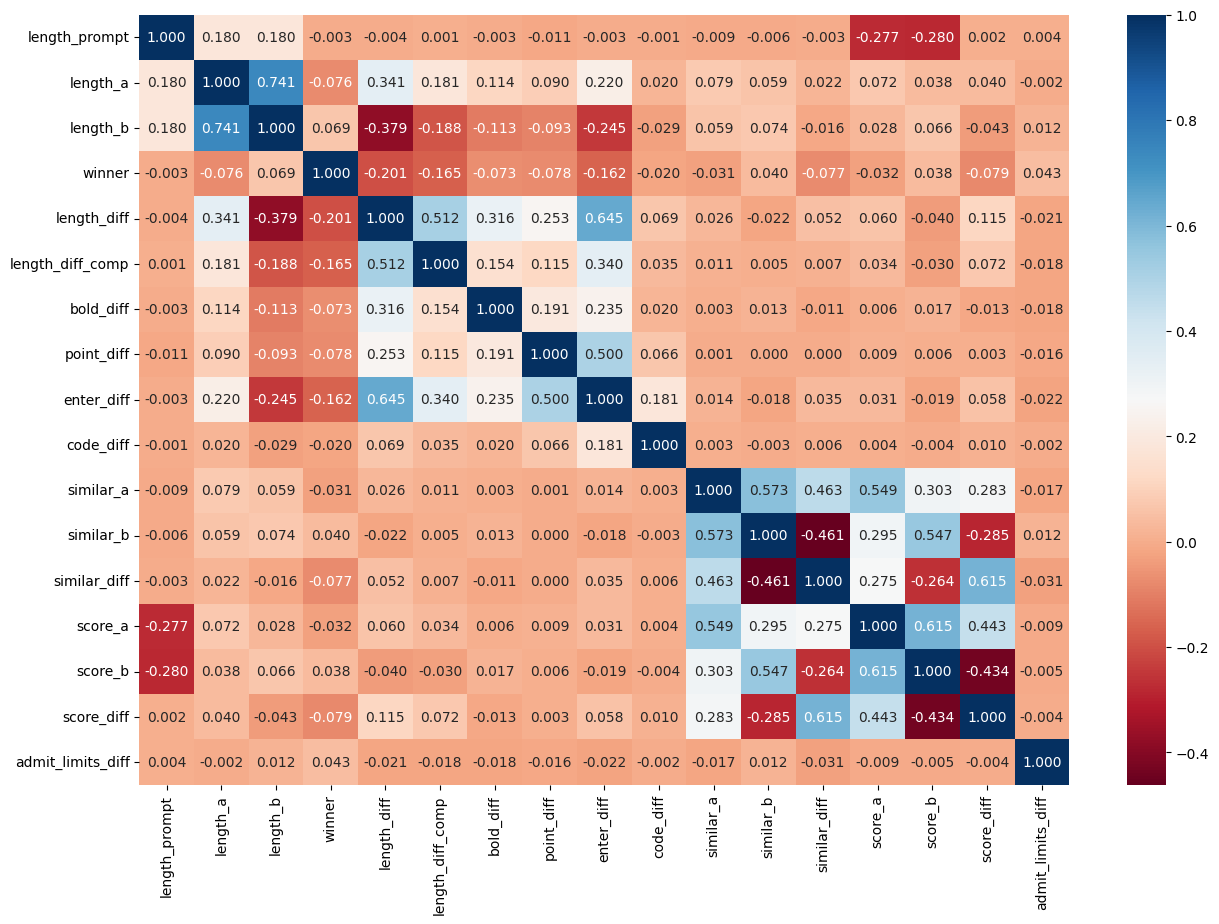

In [42]:
plt.figure(figsize=(15, 10))
sns.heatmap(train[['length_prompt','length_a','length_b','winner','length_diff','length_diff_comp','bold_diff','point_diff','enter_diff','code_diff','similar_a','similar_b','similar_diff','score_a','score_b','score_diff','admit_limits_diff']].corr(), 
            annot=True,
            cbar=True, cmap='RdBu', fmt='.3f')
plt.show()

In [43]:
df = train.drop(columns=['id','model_a','model_b','prompt','response_a','response_b','winner_model_a',
                        'winner_model_b','winner_tie'])
features = df.drop('winner', axis=1)
target = df['winner']
 
# Splitting the dataset into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                      random_state=42,
                                      test_size=0.20)

# Check the shape of both sets
X_train.shape, X_val.shape

((45981, 16), (11496, 16))

In [44]:
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'verbose': -1
}
 
# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=Y_train)
valid_data = lgb.Dataset(X_val, label=Y_val, reference=train_data)

In [45]:
num_round = 100
model = lgb.train(params,
                  train_data,
                  num_round,
                  callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(10)],
                  valid_sets=[valid_data])

Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.04681
[20]	valid_0's multi_logloss: 1.0376
[30]	valid_0's multi_logloss: 1.03525
[40]	valid_0's multi_logloss: 1.03466
[50]	valid_0's multi_logloss: 1.03399
[60]	valid_0's multi_logloss: 1.03396
[70]	valid_0's multi_logloss: 1.03414
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 1.03392


In [46]:
X_test = test.drop(columns=['id','prompt','response_a','response_b'])
print(X_test.shape)
pred_test = model.predict(X_test,
                       num_iteration=model.best_iteration)
print(pred_test.shape)

(3, 16)
(3, 3)


In [47]:
test[['winner_model_a','winner_model_b','winner_tie']] = 0
for i in range(len(test)):
    test.at[i,'winner_model_a'] = pred_test[i][0]
    test.at[i,'winner_model_b'] = pred_test[i][2]
    test.at[i,'winner_tie'] = pred_test[i][1]
sub = test.drop(columns = ['prompt','response_a','response_b','length_prompt',
                           'length_a','length_b','length_diff','length_diff_comp',
                           'bold_diff','point_diff','enter_diff','code_diff',
                           'similar_a','similar_b','similar_diff',
                           'score_a','score_b','score_diff'])
sub.to_csv('submission.csv', index=False)

In [23]:
#!zip -r file.zip /kaggle/working
#from IPython.display import FileLink
#FileLink(r'file.zip')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


updating: kaggle/working/ (stored 0%)
updating: kaggle/working/similar_model/ (stored 0%)
updating: kaggle/working/similar_model/vocab.txt (deflated 53%)
updating: kaggle/working/similar_model/model.safetensors (deflated 8%)
updating: kaggle/working/similar_model/tokenizer.json (deflated 71%)
updating: kaggle/working/similar_model/config_sentence_transformers.json (deflated 35%)
updating: kaggle/working/similar_model/config.json (deflated 47%)
updating: kaggle/working/similar_model/2_Normalize/ (stored 0%)
updating: kaggle/working/similar_model/1_Pooling/ (stored 0%)
updating: kaggle/working/similar_model/1_Pooling/config.json (deflated 57%)
updating: kaggle/working/similar_model/special_tokens_map.json (deflated 85%)
updating: kaggle/working/similar_model/sentence_bert_config.json (deflated 4%)
updating: kaggle/working/similar_model/README.md (deflated 62%)
updating: kaggle/working/similar_model/modules.json (deflated 62%)
updating: kaggle/working/similar_model/tokenizer_config.json (

/kaggle/working/file.zip